In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from funciones import formato_fechas
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../Datos/Datos UX/page_views_2.csv', sep=';', parse_dates=['event_timestamp_'])
df.drop(columns=['event_date_','event_name'], inplace=True)
df = df.sort_values(by=['user_id', 'event_timestamp_'])

In [3]:
orden_quiz = ["quiz_leisure", "quiz_work", "quiz_fit","quiz_highlight","quiz_bodyShape", "quiz_eyes", "quiz_hair",
              "quiz_sizes", "quiz_measurements", "quiz_focus", "quiz_adventurous", "quiz_styles",
              "quiz_prices", "quiz_avoid", "quiz_footwear", "quiz_you", "quiz_photos", "quiz_social", "quiz_signUp"]

# Procesamiento

In [4]:
# 1. Timestamp del siguiente evento global
df['timestamp_siguiente'] = df.groupby('user_id')['event_timestamp_'].shift(-1)

# 2. Duración entre evento actual y siguiente evento global
df['duracion_hasta_siguiente'] = (df['timestamp_siguiente'] - df['event_timestamp_']).dt.total_seconds()

# 3. Timestamp del evento anterior
df['timestamp_anterior'] = df.groupby('user_id')['event_timestamp_'].shift(1)

# 4. Sección anterior visitada por el usuario
df['seccion_anterior'] = df.groupby('user_id')['section'].shift(1)

# 5. Tiempo desde el evento anterior
df['tiempo_desde_anterior'] = (df['event_timestamp_'] - df['timestamp_anterior']).dt.total_seconds()

# 6. ID de la sesion --> Una nueva sesion se considera cuando esta mas de 1 hora para pasar a la siguiente pregunta 
df['nueva_sesion'] = (df['duracion_hasta_siguiente'] > 60 * 60) | (df['duracion_hasta_siguiente'].isna())
df['session_id'] = df.groupby('user_id')['nueva_sesion'].cumsum()

# 7. Timestamp siguiente dentro de la misma sesión
df['timestamp_siguiente_sesion'] = df.groupby(['user_id', 'session_id'])['event_timestamp_'].shift(-1)

# 8. Duración real en la sección dentro de la sesión
df['duracion_en_seccion'] = (df['timestamp_siguiente_sesion'] - df['event_timestamp_']).dt.total_seconds()

# 9. Sección siguiente dentro de la sesión
df['seccion_siguiente'] = df.groupby(['user_id', 'session_id'])['section'].shift(-1)

# 10. Pausa hasta el siguiente evento global (para abandono)
df['pausa_hasta_siguiente'] = (df['timestamp_siguiente'] - df['event_timestamp_']).dt.total_seconds()

UMBRAL_SEGUNDOS = 60 * 60

## EXPLORACION INICIAL

In [5]:
usuarios_totales = df['user_id'].nunique()
usuarios_totales

41

In [6]:
preguntas_totales = df['section'].nunique()
preguntas_totales

19

Se considera que han acabado, aquellas personas que llegan al signup y no realizan mas pasos

In [7]:
ultimo_evento = df.groupby('user_id').tail(1).copy()
usuarios_exito_real = ultimo_evento[ultimo_evento['section'] == 'quiz_signUp']['user_id'].unique()
len(usuarios_exito_real)

32

# Usuarios Que Han Realizado el Test

In [8]:
secciones_obligatorias = set(orden_quiz) - {'quiz_leisure'}

analisis = []
df_exitosos = df[df['user_id'].isin(usuarios_exito_real)]

for user in usuarios_exito_real:
    secciones_visitadas = set(df_exitosos[df_exitosos['user_id'] == user]['section'].unique())    
    falta = secciones_obligatorias - secciones_visitadas
    
    analisis.append({
        'user_id': user,
        'Hizo_Todo': len(falta) == 0,
        'Secciones_Saltadas': list(falta)
    })

df_completado = pd.DataFrame(analisis)

print(f"Total Usuarios que terminaron: {len(df_completado)}")
print(f"Usuarios con recorrido perfecto: {len(df_completado[df_completado['Hizo_Todo']])}")
print(f"Usuarios con saltos: {len(df_completado[~df_completado['Hizo_Todo']])}")

print("\n¿QUÉ SE SALTA LA GENTE QUE TERMINA?")
print(df_completado[~df_completado['Hizo_Todo']][['user_id', 'Secciones_Saltadas']].to_string(index=False))

Total Usuarios que terminaron: 32
Usuarios con recorrido perfecto: 22
Usuarios con saltos: 10

¿QUÉ SE SALTA LA GENTE QUE TERMINA?
                         user_id Secciones_Saltadas
1932240bef894979be69257cc5431843    [quiz_footwear]
287cd4480785430b83bb19f93318a7b7    [quiz_footwear]
28afb6f2fecb45508fb35ed818927b57    [quiz_footwear]
5379734ea78c4b0f9580fb994ac93510    [quiz_footwear]
90a01965db9a4092a66ac88a6906ab68    [quiz_footwear]
963c4eb5c1cd45aebfd2e6d184becd5e    [quiz_footwear]
a99226f446db4bc4aa8f69260a228ba8    [quiz_footwear]
c122da2281a540c8a9fdac722a0c4b7e    [quiz_footwear]
e0916cdf04854e68843f08688da90679    [quiz_footwear]
f220a4ac51cd42bfb73714a4edd45b9e    [quiz_footwear]


# Mediana de Preguntas

In [9]:
# 2. Preguntas de +60 min se borran porque se considera que ha abandonado el cuestionario
df_tiempos = df[df['duracion_hasta_siguiente'].notna() & (df['duracion_hasta_siguiente'] < UMBRAL_SEGUNDOS)].copy()

# 3. Tabla de tiempos por sección
tabla_tiempos = (df_tiempos.groupby('section')['duracion_hasta_siguiente'].agg(['median', 'count']).reset_index())
tabla_tiempos.columns = ['section', 'mediana_segundos', 'usuarios_medibles']

# 4. Tráfico total real por sección
tabla_trafico = (df.groupby('section')['user_id'].count().reset_index())
tabla_trafico.columns = ['section', 'trafico_total_real']

resultado = pd.merge(tabla_trafico, tabla_tiempos, on='section', how='left')

resultado['section'] = pd.Categorical(resultado['section'], categories=orden_quiz, ordered=True)
resultado = resultado.sort_values('section')

print(resultado[['section', 'trafico_total_real', 'mediana_segundos']].to_string(index=False))

          section  trafico_total_real  mediana_segundos
     quiz_leisure                  24         11.248215
        quiz_work                  45          9.181293
         quiz_fit                  44         16.823730
   quiz_highlight                  44         20.634527
   quiz_bodyShape                  44         30.371002
        quiz_eyes                  43          9.158109
        quiz_hair                  46          6.682356
       quiz_sizes                  44         27.590783
quiz_measurements                  43         12.242307
       quiz_focus                  41         16.643335
 quiz_adventurous                  44         22.807763
      quiz_styles                  47         51.587092
      quiz_prices                  44         11.857911
       quiz_avoid                  42         18.498041
    quiz_footwear                  30         27.532795
         quiz_you                  42         19.043753
      quiz_photos                  42         61

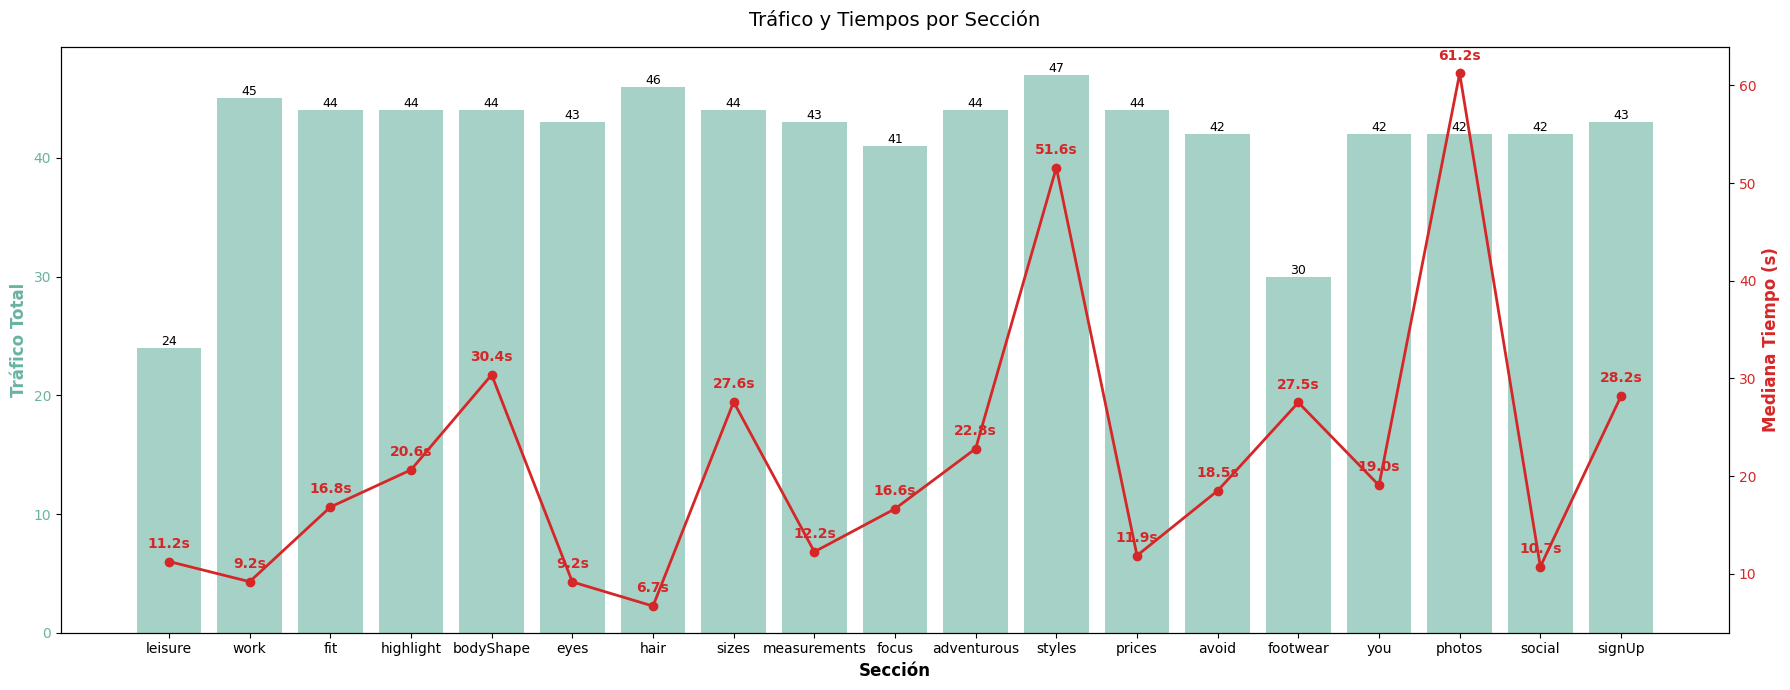

In [10]:
x_labels = resultado['section'].astype(str).str.replace('quiz_', '', regex=False)
fig, ax1 = plt.subplots(figsize=(18, 7))

color_barras = '#69b3a2'
ax1.set_xlabel('Sección', fontsize=12, fontweight='bold')
ax1.set_ylabel('Tráfico Total', color=color_barras, fontsize=12, fontweight='bold')

barras = ax1.bar(x_labels, resultado['trafico_total_real'], color=color_barras, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color_barras)

for bar in barras:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=9)

ax2 = ax1.twinx()
color_linea = '#d62728'
ax2.set_ylabel('Mediana Tiempo (s)', color=color_linea, fontsize=12, fontweight='bold')

ax2.plot(x_labels, resultado['mediana_segundos'], color=color_linea, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color_linea)

for i, val in enumerate(resultado['mediana_segundos']):
    if pd.notna(val):
        ax2.annotate(f"{val:.1f}s", 
                     (i, val),
                     xytext=(0, 10), textcoords='offset points', 
                     ha='center', color=color_linea, fontweight='bold')

plt.title('Tráfico y Tiempos por Sección', fontsize=14, pad=15)
plt.tight_layout()
plt.show()

------------------------

In [11]:
df_retornos = df[df['tiempo_desde_anterior'] > UMBRAL_SEGUNDOS].copy()
lista_analisis = []

for idx, row in df_retornos.iterrows():
    usuario = row['user_id']
    fecha_retorno = row['event_timestamp_']
    
    # Buscar el siguiente retorno del mismo usuario
    proximos = df_retornos[(df_retornos['user_id'] == usuario) & (df_retornos['event_timestamp_'] > fecha_retorno)
                           ].sort_values('event_timestamp_')
    
    if not proximos.empty:
        fecha_limite = proximos.iloc[0]['event_timestamp_']
        eventos_sesion = df[(df['user_id'] == usuario) & (df['event_timestamp_'] >= fecha_retorno) & (df['event_timestamp_'] < fecha_limite)]
    else:
        eventos_sesion = df[(df['user_id'] == usuario) & (df['event_timestamp_'] >= fecha_retorno)]
    
    if not eventos_sesion.empty:
        ultima_seccion = eventos_sesion.iloc[-1]['section']
        completo = "SÍ" if ultima_seccion == 'quiz_signUp' else "NO"
    else:
        completo = "NO"
    
    lista_analisis.append({
        'usuario': usuario, 'abandono_en': row['seccion_anterior'], 'volvio_en': row['section'], 
        'tiempo_ausente': formato_fechas(row['tiempo_desde_anterior']), 'completo': completo})
df_retorno_resultado = pd.DataFrame(lista_analisis)

# 2. ABANDONO GENERAL (pausas largas >1h o último evento del usuario)
mask_pausa = (df['pausa_hasta_siguiente'] > UMBRAL_SEGUNDOS) | (df['pausa_hasta_siguiente'].isna())
df_pausas = df[mask_pausa].copy()

tabla_abandono_general = (df_pausas['section'].value_counts().reset_index())

tabla_abandono_general.columns = ['seccion', 'total_pausas']
tabla_abandono_general['porcentaje'] = (tabla_abandono_general['total_pausas'] / len(df_pausas) * 100).round(2)

tabla_abandono_general['tipo'] = tabla_abandono_general['seccion'].apply(lambda x: 'Completado' if x == 'quiz_signUp' else 'Abandono')


# 3. ANÁLISIS DE CHURN REAL (nunca completaron)
ultimo_evento = df.groupby('user_id').tail(1).copy()
usuarios_exito = ultimo_evento[ultimo_evento['section'] == 'quiz_signUp']['user_id'].unique()

df_churn_real = ultimo_evento[~ultimo_evento['user_id'].isin(usuarios_exito)].copy()

ranking_churn = (df_churn_real['section'].value_counts().reset_index())

ranking_churn.columns = ['seccion_mortal', 'usuarios_perdidos']
ranking_churn['porcentaje'] = (ranking_churn['usuarios_perdidos'] / len(df_churn_real) * 100).round(2)

print("1. ANÁLISIS DE ABANDONO (Cualquier pausa > 1h)")
print(f"Total de sesiones finalizadas/pausadas: {len(df_pausas)}")
print(tabla_abandono_general.head(10).to_string(index=False))

print(f"\n2. ANÁLISIS DE RETORNOS (Usuarios que regresan tras pausa larga)")
if not df_retorno_resultado.empty:
    recuperados = len(df_retorno_resultado[df_retorno_resultado['completo']=='SÍ'])
    total_retornos = len(df_retorno_resultado)
    
    print(f"Pausas largas >1H : {total_retornos}")
    print(f"Sesiones recuperadas completamente: {recuperados} ({recuperados/total_retornos*100:.1f}%)")
    
    cols = ['usuario', 'abandono_en', 'volvio_en', 'tiempo_ausente', 'completo']
    print(df_retorno_resultado[df_retorno_resultado['completo']=='SÍ'][cols].to_string(index=False))
else:
    print("No hay retornos registrados.")

print(f"\n3. ANÁLISIS DE CHURN REAL (usuarios que nunca completaron)")
print(f"Total usuarios fallidos: {len(df_churn_real)}")
print(ranking_churn.head(5).to_string(index=False))

1. ANÁLISIS DE ABANDONO (Cualquier pausa > 1h)
Total de sesiones finalizadas/pausadas: 52
          seccion  total_pausas  porcentaje       tipo
      quiz_signUp            35       67.31 Completado
     quiz_leisure             8       15.38   Abandono
        quiz_work             2        3.85   Abandono
      quiz_social             2        3.85   Abandono
        quiz_hair             1        1.92   Abandono
      quiz_photos             1        1.92   Abandono
         quiz_fit             1        1.92   Abandono
       quiz_sizes             1        1.92   Abandono
quiz_measurements             1        1.92   Abandono

2. ANÁLISIS DE RETORNOS (Usuarios que regresan tras pausa larga)
Pausas largas >1H : 11
Sesiones recuperadas completamente: 5 (45.5%)
                         usuario       abandono_en         volvio_en tiempo_ausente completo
08524cc6b3544d65af7faa39e9abd3f2       quiz_signUp       quiz_signUp         5h 28m       SÍ
287cd4480785430b83bb19f93318a7b7       

Porque en abandono general no sale signUP si en analisis de retornos muestra que han abandonado en quiz_signUp

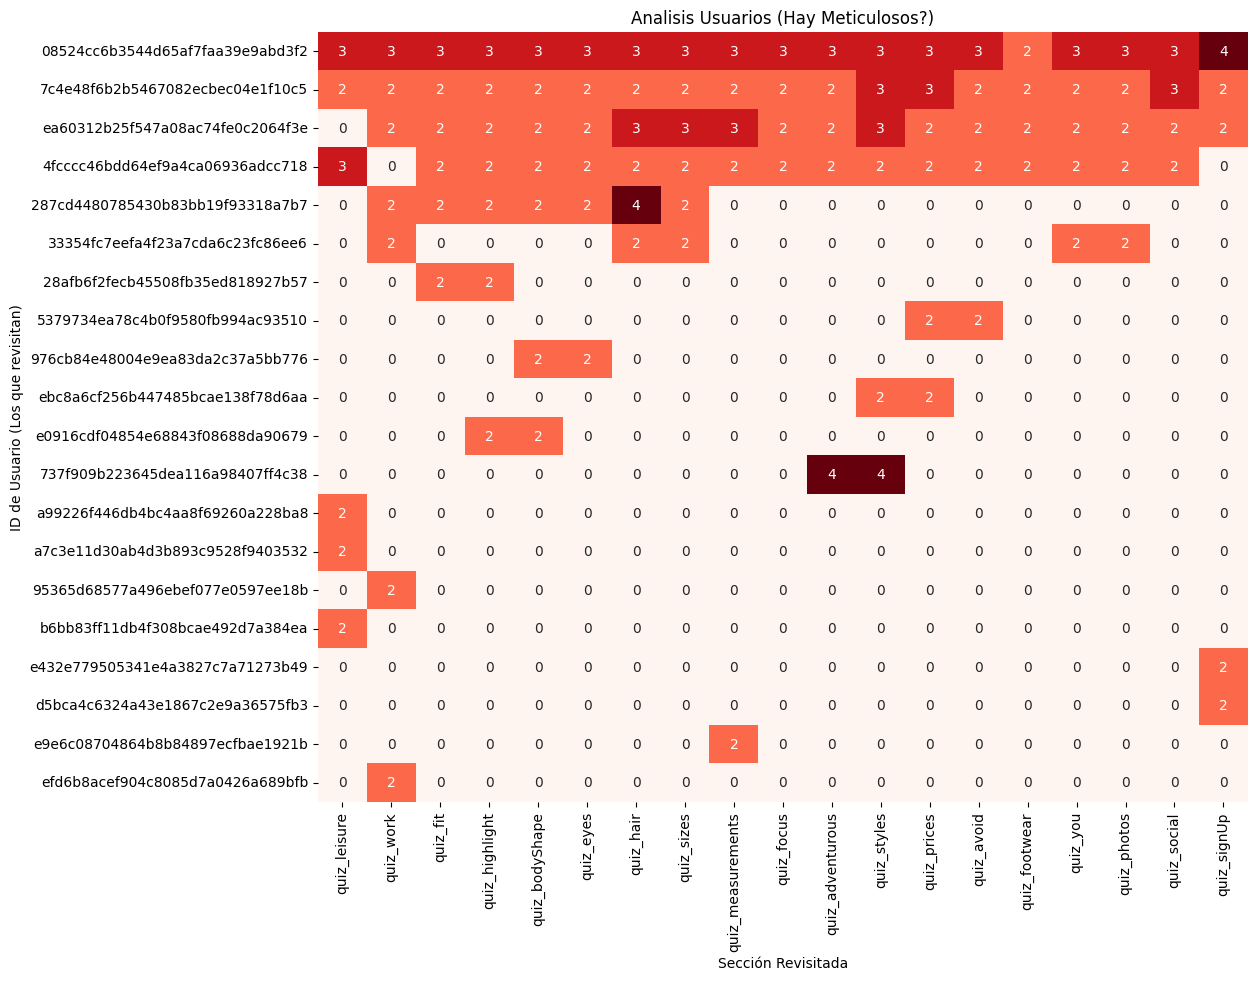


RANKING DE PREGUNTAS CON MÁS DUDAS (Revisitas)
          Sección  Usuarios_Revisitando  Intensidad_Media
   quiz_bodyShape                     7               2.1
        quiz_work                     7               2.1
   quiz_highlight                     7               2.1
       quiz_sizes                     6               2.3
      quiz_styles                     6               2.8
        quiz_hair                     6               2.7
        quiz_eyes                     6               2.2
     quiz_leisure                     6               2.3
         quiz_fit                     6               2.2
      quiz_prices                     6               2.3
 quiz_adventurous                     5               2.6
       quiz_avoid                     5               2.2
      quiz_signUp                     5               2.4
quiz_measurements                     5               2.4
      quiz_photos                     5               2.2
         quiz_you       

In [ ]:
visitas = df.groupby(['user_id', 'section']).size().reset_index(name='n_visitas')
loopers = visitas[visitas['n_visitas'] > 1].copy()

matriz_loops = loopers.pivot(index='user_id', columns='section', values='n_visitas')

matriz_loops = matriz_loops.fillna(0)

matriz_loops['Secciones_Diferentes_Revisitadas'] = (matriz_loops > 0).sum(axis=1)
matriz_loops = matriz_loops.sort_values('Secciones_Diferentes_Revisitadas', ascending=False)

plot_data = matriz_loops.drop(columns=['Secciones_Diferentes_Revisitadas'])

cols_ordenadas = [c for c in orden_quiz if c in plot_data.columns]
plot_data = plot_data[cols_ordenadas]

plt.figure(figsize=(12, 10))
sns.heatmap(plot_data, cmap="Reds", annot=True, cbar=False, fmt='g')
plt.title("Analisis Usuarios (Hay Meticulosos?)")
plt.ylabel("ID de Usuario (Los que revisitan)")
plt.xlabel("Sección Revisitada")
plt.yticks(rotation=0)
plt.show()

In [13]:
transitions = []

for uid, grp in df.groupby('user_id'):
    sections = grp['section'].tolist()
    for a,b in zip(sections, sections[1:]):
        transitions.append((a,b))

trans_df = pd.DataFrame(transitions, columns=['from','to'])

matriz = pd.crosstab(trans_df['from'], trans_df['to'])
M = matriz.to_numpy()

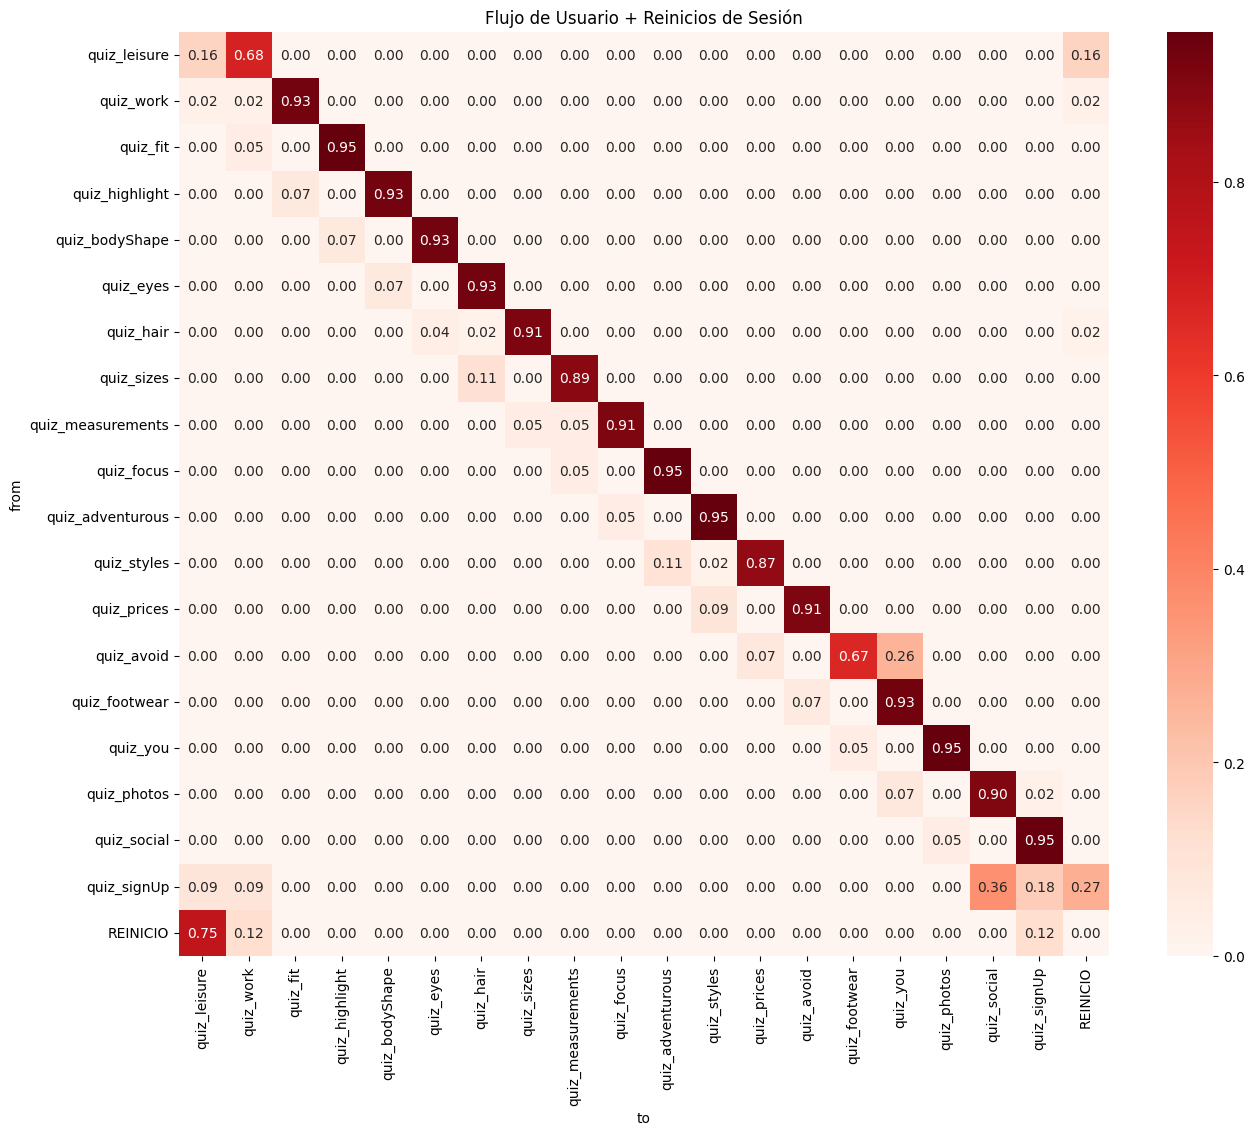

In [14]:
transiciones = []
for uid, grp in df.groupby('user_id'):
    preguntas = grp['section'].tolist()
    # Usamos la pausa que definiste para detectar el fin de sesión
    pausas = grp['pausa_hasta_siguiente'].tolist() 
    
    for i in range(len(preguntas) - 1):
        origen = preguntas[i]
        destino = preguntas[i+1]
        gap = pausas[i] # Tiempo que pasa desde 'origen' hasta el siguiente evento
        
        if gap > 60 * 240: # 4 Horas
            # El usuario se detuvo aquí y volvió después de >4h
            transiciones.append((origen, "REINICIO"))
            transiciones.append(("REINICIO", destino))
        else:
            transiciones.append((origen, destino))

df_trans = pd.DataFrame(transiciones, columns=['from', 'to'])
orden_extendido = orden_quiz + ["REINICIO"]

matriz_m = pd.crosstab(df_trans['from'], df_trans['to'])
matriz_m = matriz_m.reindex(index=orden_extendido, columns=orden_extendido, fill_value=0)

prob_matriz = matriz_m.div(matriz_m.sum(axis=1).replace(0, 1), axis=0)

plt.figure(figsize=(15, 12))
sns.heatmap(prob_matriz, annot=True, fmt=".2f", cmap="Reds")
plt.title("Flujo de Usuario + Reinicios de Sesión")
plt.show()

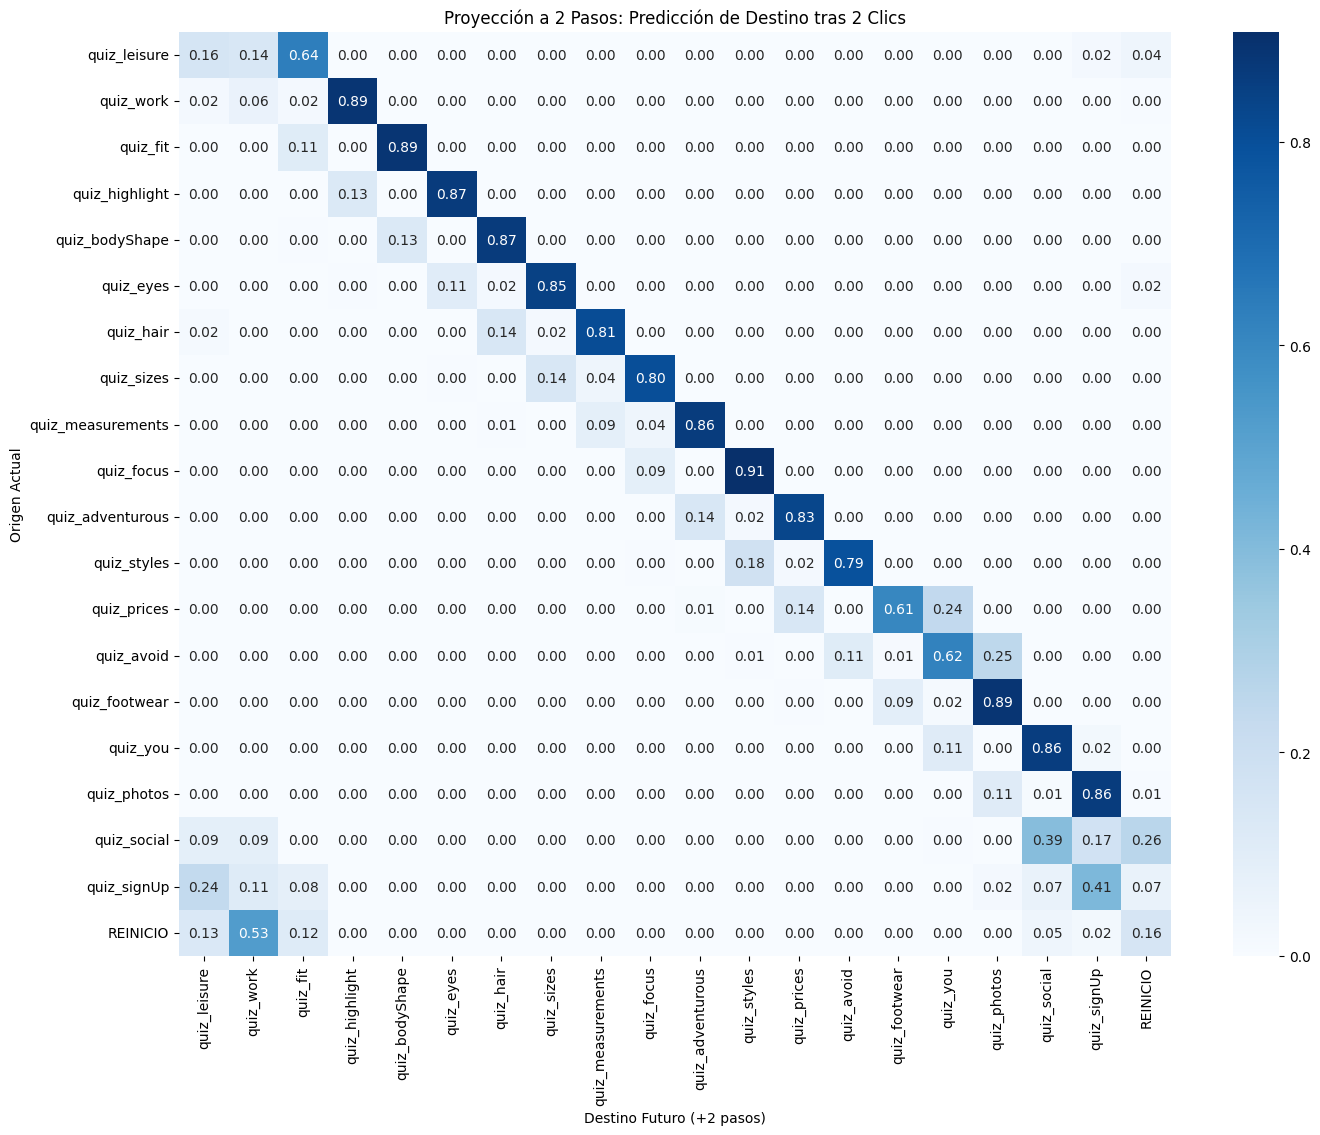

In [15]:
M_prob = prob_matriz.to_numpy() 
M2_prob = M_prob @ M_prob
df_m2 = pd.DataFrame(M2_prob, index=orden_extendido, columns=orden_extendido)

plt.figure(figsize=(16, 12))
sns.heatmap(df_m2, cmap="Blues", annot=True, fmt=".2f")
plt.title("Proyección a 2 Pasos: Predicción de Destino tras 2 Clics")
plt.xlabel("Destino Futuro (+2 pasos)")
plt.ylabel("Origen Actual")
plt.show()

# COMPORTAMIENTO USUARIO EN FUNCION DEL MOVIMIENTO QUE HACE

In [16]:
orden_seccion = {sec: i for i, sec in enumerate(orden_quiz)}
df['orden_actual'] = df['section'].map(orden_seccion)
df['orden_siguiente'] = df['seccion_siguiente'].map(orden_seccion)

def clasificar_movimiento(row):
    if pd.isna(row['seccion_siguiente']):
        return 'Salida'
    if pd.isna(row['orden_actual']) or pd.isna(row['orden_siguiente']):
        return 'Desconocido'
    
    diff = row['orden_siguiente'] - row['orden_actual']
    if diff == 0: 
        return 'Bucle'
    elif diff > 0: 
        return 'Adelante'
    else: 
        return 'Atras'

df['tipo_movimiento'] = df.apply(clasificar_movimiento, axis=1)

df_decision = df[df['tipo_movimiento'].isin(['Adelante', 'Atras', 'Bucle']) & 
                 (df['duracion_en_seccion'] < UMBRAL_SEGUNDOS)].copy()

resumen_movimiento = df_decision.groupby(['section', 'tipo_movimiento'])['duracion_en_seccion'] \
    .agg(['median', 'count']).unstack()

# Aplanar nombres de columnas
resumen_movimiento.columns = ['_'.join(col).strip() for col in resumen_movimiento.columns.values]

# --- 4. RENOMBRAR Y FILTRAR ---
mapa_renombrar = {
    'median_Adelante': 'Avanza_Mediana', 'count_Adelante': 'Avanza_Usuarios',
    'median_Atras': 'Retrocede_Mediana', 'count_Atras': 'Retrocede_Usuarios',
    'median_Bucle': 'Bucle_Mediana', 'count_Bucle': 'Bucle_Usuarios'
}
resumen_total = resumen_movimiento.rename(columns=mapa_renombrar)

# Asegurar orden del quiz y visualización
secciones_validas = [s for s in orden_quiz if s in resumen_total.index]
display(resumen_total.loc[secciones_validas].fillna(0).round(1))

,Avanza_Mediana,Retrocede_Mediana,Bucle_Mediana,Avanza_Usuarios,Retrocede_Usuarios,Bucle_Usuarios
section,,,,,,
quiz_leisure,10.6,0.0,521.2,13.0,0.0,2.0
quiz_work,9.2,0.0,22.3,41.0,1.0,1.0
quiz_fit,17.5,0.0,0.0,41.0,1.0,0.0
quiz_highlight,20.8,5.0,0.0,41.0,2.0,0.0
quiz_bodyShape,31.1,5.8,0.0,41.0,3.0,0.0
quiz_eyes,10.1,0.0,0.0,40.0,3.0,0.0
quiz_hair,6.7,5.8,0.0,41.0,2.0,0.0
quiz_sizes,29.5,12.2,0.0,38.0,5.0,0.0
quiz_measurements,12.3,0.0,32.4,39.0,2.0,1.0
